In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_HALF_UP
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib as mpl
import math
import re
import os
from colour import Color
from cycler import cycler
from IPython.core.display import display, HTML

In [2]:
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': False})
sns.set_style('whitegrid')

In [3]:
year = 2018
event = 'dh'
race = 3
gender = 'm'
topX = 20
splits = 5 # Could detect this from dataset, or or they always 5? @todo
image_gen = True
dpi = 300

In [4]:
from config import races

racename = races[year][race]['name']
raceName = races[year][race]['title']
chart_title_prefix = raceName + ( ', Men' if gender == 'm' else ', Women' )

In [5]:
directory = event + str(race) + '_' + racename
file_prefix = event + str(race) + '_' + racename + '_' + gender
file_prefix_l = os.path.join( directory, str(year-1) + '_' + file_prefix )
file_prefix = os.path.join( directory, file_prefix )

In [6]:
# df = pd.read_csv( file_prefix + '.results.csv', index_col=0 )
# df = df.dropna() # remove DNF/DNS

df = pd.read_csv( file_prefix + '.merged.csv', index_col=0 )
dfl = pd.read_csv( file_prefix_l + '.merged.csv', index_col=0 )

In [7]:
dlen = len( df['status'].dropna() )
if topX > dlen:
    topX = dlen

In [8]:
def formatDelta( time ):
    return ':'.join(str(time).split(':')[1:3])[:-3]

In [9]:
def convertToDelta( timestring ):
    timestring = str(timestring)

    if ":" not in timestring:
        timestring = str( cRound( timestring ) )
        timestring = "0:" + timestring

    timestring = "0:" + timestring

    return pd.to_timedelta( timestring )

In [10]:
def cRound( flt ):
    return float( Decimal( flt ).quantize( Decimal('.001' ), rounding=ROUND_HALF_UP ) )

In [38]:
def secondsToRaceTime( seconds ):
    return '%2dm%02ds' % divmod( seconds, 60 )

[<matplotlib.lines.Line2D at 0xb95ad0>, <matplotlib.lines.Line2D at 0xb7f130>]

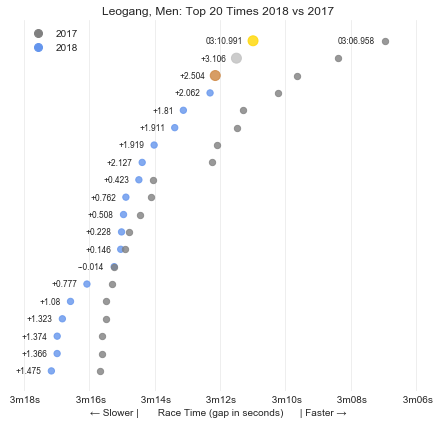

In [85]:
df2 = df
col = 'split5'
title = chart_title_prefix + ': Top ' + str(topX) + ' Times ' + str(year) + ' vs ' + str(year-1)
timeCol=False
maxX=dfl[:topX].split5.min()-1
minX=df[:topX].split5.max()+1
color='cornflowerblue'
xlabel='← Slower |       Race Time (gap in seconds)      | Faster →'
labelPosOffsetX=.3


pltY = 3 * math.ceil( topX / 10 )
pltX = 2.5 * math.ceil( topX / 10 )+1
plt.subplots(figsize=(pltX,pltY))
#     plt.subplots()

if False == minX:
    minX = df2[col][:topX].max()
if False == maxX:
    maxX = -.9
#         maxX = df2[col].max()# - (df2[col].min()*.1)  #-.5
#         display( maxX )

# Build list of plot colors and sizes, then alter those entries for final 1,2,3 finishers
colors = [color]*(len(df2[col]))
colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
sizes = [40]*(len(df2[col]))
sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100

# Build the chart
plot = sns.regplot( y=df2.index.values[0:topX], x=df2[col][0:topX], fit_reg=False, scatter_kws={'color': colors, 's': sizes} )
plot1 = sns.regplot( y=dfl.index.values[0:topX], x=dfl[col][0:topX], fit_reg=False, scatter_kws={'color': 'grey', 's': 40} )
plot.invert_yaxis()
plot.invert_xaxis()
plt.xlim( minX, maxX )

# Format the chart
sns.despine()
plot.yaxis.set_visible(False)
plot.set_frame_on(False)
plot.grid( color='#EEEEEE', linewidth=1.0 )
plot.set( title=title, xlabel=xlabel )

# Reference column to display 1st place actual time rather than difference
coln = col[:6] + ( "_sector" if col[7:9] != "vs" else "" ) if timeCol == False else False

# Add labels to data points
for row in range( 0, topX ):
    if 0 == row and coln:
        label = formatDelta( convertToDelta( df2[col][row] ) )
        x2 = dfl[col][row] + labelPosOffsetX
        label2 = formatDelta( convertToDelta( dfl[col][row] ) )
    else:
        diff = df2[col][row] - dfl[col][row]
        label = ( '+' if 0 < diff else '-' ) + str(diff)
        x2 = False

    # Time gaps
    x = df2[col][row] + labelPosOffsetX
    y = df2.index.values[row] + 0.15
    plot.text( x, y, label, horizontalalignment='right', size='small' )

    if x2:
        plot.text( x2, y, label2, horizontalalignment='right', size='small' )
    
    # Position
#     px = dfl[col][row] - labelPosOffsetX
#     py = dfl.index.values[row] + 0.15
#     plot.text( px, py, int(dfl['rank'][row]), horizontalalignment='left', size='small' )


leg1 = mlines.Line2D( [], [], color='grey', marker='o', markersize=8, label='2017', linestyle='' )
leg2 = mlines.Line2D( [], [], color='cornflowerblue', marker='o', markersize=8, label='2018', linestyle='' )
display( [leg1, leg2] )
plt.legend( handles=[leg1, leg2] )
        
plt.tight_layout()

xticks = [ secondsToRaceTime( int(t.get_text()) ) if 'm' not in t.get_text() else t.get_text() for t in plot.get_xticklabels() ]
plot.set_xticklabels( xticks )

if image_gen:
#     plt.gcf().subplots_adjust(left=0.3)
    plt.savefig( file_prefix + '_' + re.sub( '__', '_', re.sub( '[ :,]', '_', title[title.find( ':' )+2:].lower() ) ) + '.png', dpi=dpi )

In [82]:
display( "Mean difference" )
col = 'split5'
pd.DataFrame( [ df2[col][row] - dfl[col][row] for row in range( 0, topX ) ] ).mean()

'Mean difference'

0    1.446
dtype: float64